# Scope
Defense techniques for Split Learning

Setting up the defense pipeline

Comparing the leakage

Limitations

# Recap

Split Learning

X--> [Client NN] --> Z --> [Server NN] --> Y


X [Client NN] <-- lossZ <-- [Server NN] <-- Y

# Defense Techniques for Split Learning

Two broad categories

Informal and semantically driven methods

Fromal methods with guarantees

(focus on informal methods)


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.autograd import Variable
from matplotlib import pyplot as plt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

#CIFAR 10 is a dataset of natural images consisting of 50k training images and 10k test
#Every image is labelled with one of the following class
classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

trainset = torchvision.datasets.CIFAR10(root='./data',train = True, download = True,transform = transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=128,shuffle= True,num_workers = 2)

testset = torchvision.datasets.CIFAR10(root = './data', train = False,download = True,transform = transform)
testloader = torch.utils.data.DataLoader(testset,batch_size = 128,shuffle = True,num_workers = 2)


100%|██████████| 170498071/170498071 [00:13<00:00, 13024962.93it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
class ResNet18Client(nn.Module):
    """ docstring for ResNet """
    #Explain initialize (listing the neural network architecture and other related parameters)
    def __init__(self,config):
        super(ResNet18Client,self).__init__()
        #Declare where we are going to split the NN, if cut layer close to output most computation will happen in the client side
        self.cut_layer = config["cut_layer"]

        #Load the resnet model
        self.model = models.resnet18(pretrained = False)
        self.model = nn.ModuleList(self.model.children())
        self.model = nn.Sequential(*self.model)

    def forward(self,x):
        for i,l in enumerate(self.model):
            if i> self.cut_layer:
                break
            x = l(x)
        return x

class ResNet18Server(nn.Module):
    """ docstring for ResNet """
    def __init__(self,config):
        super(ResNet18Server,self).__init__()
        self.logits = config["logits"]
        self.cut_layer = config["cut_layer"]

        self.model = models.resnet18(pretrained = False)
        num_ftrs = self.model.fc.in_features

        self.model.fc = nn.Sequential(nn.Flatten(),nn.Linear(num_ftrs,self.logits))
        self.model = nn.ModuleList(self.model.children())
        self.model = nn.Sequential(*self.model)

    def forward(self,x):
        for i,l in enumerate(self.model):
            #continue until you are in the cut layer, skip earlier layers
            if i<=self.cut_layer:
                continue
            x = l(x)
        return nn.functional.softmax(x,dim=1)


In [4]:
"""#Initialize the Models"""

config = {'cut_layer':7,"logits":10} #logits = 10 cause we are using ciphar10 that has 10 classes
client_model = ResNet18Client(config).to(device)
server_model = ResNet18Server(config).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:
"""Set up the optimizer"""
criterion = nn.CrossEntropyLoss()
client_optimizer = optim.SGD(client_model.parameters(),lr=0.01,momentum=0.9)
server_optimizer = optim.SGD(server_model.parameters(),lr=0.01,momentum = 0.9)


In [7]:
"""Perform training"""

num_epochs = 50
for epoch in range(num_epochs):
    running_loss = 0.0
    for i,data in enumerate(trainloader,0):
        inputs, labels = data[0].to(device), data[1].to(device)

        client_optimizer.zero_grad()
        server_optimizer.zero_grad()

        #Client Part
        activations = client_model(inputs)
        server_inputs = activations.detach().clone() # get the outputs of the client and input them to the server

        #Simulation of sever part is happening in this portion
        #Server part
        server_inputs = Variable(server_inputs,requires_grad = True)
        outputs = server_model(server_inputs)
        loss = criterion(outputs,labels)
        loss.backward()

        #Server optimization
        server_optimizer.step()

        #Simulation of Client Happening in this portion
        #Client optimization
        activations.backward(server_inputs.grad)
        client_optimizer.step()

        running_loss += loss.item()

        if i % 200 == 199:
            print("[{},{}] loss: {}".format(epoch+1,i+1,running_loss/200))
            running_loss = 0

[1,200] loss: 2.050152394771576
[2,200] loss: 1.9534108382463455
[3,200] loss: 1.8929683047533035
[4,200] loss: 1.8509011572599412
[5,200] loss: 1.8248769241571425
[6,200] loss: 1.7951378244161607
[7,200] loss: 1.7805582779645919
[8,200] loss: 1.756962924003601
[9,200] loss: 1.7478003668785096
[10,200] loss: 1.7349838542938232
[11,200] loss: 1.713525875210762
[12,200] loss: 1.7071250486373901
[13,200] loss: 1.6912043708562852
[14,200] loss: 1.6820601135492326
[15,200] loss: 1.677931364774704
[16,200] loss: 1.6665712076425552
[17,200] loss: 1.6596647280454635
[18,200] loss: 1.6440374183654785
[19,200] loss: 1.632595043182373
[20,200] loss: 1.629207438826561
[21,200] loss: 1.619295557141304
[22,200] loss: 1.6117214155197144
[23,200] loss: 1.6096484416723251
[24,200] loss: 1.5996328276395797
[25,200] loss: 1.5992393881082534
[26,200] loss: 1.5930851513147355
[27,200] loss: 1.590867908000946
[28,200] loss: 1.5791501659154892
[29,200] loss: 1.5808519089221955
[30,200] loss: 1.57436374425888

KeyboardInterrupt: ignored

In [8]:
"""#Measure the Test Set Performance"""
total, correct = 0, 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = server_model(client_model(inputs))
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted==labels).sum().item()
    print(correct/total)


0.7301


In [19]:
def reconstruction_loss(img1,img2):
    return F.l1_loss(img1,img2)
    #return nn.L1Loss(img1,img2)

class ResnetBlock(nn.Module):
    """ Define a Resnet Block """

    def __init__(self,dim,padding_type,norm_layer,use_dropout,use_bias):
        """ Initialize Resnet Block
        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip conncetions in <forward> function.
        """
        super(ResnetBlock,self).__init__()
        self.conv_block = self.build_conv_block(dim,padding_type,norm_layer,use_dropout,use_bias)

    def build_conv_block(self,dim,padding_type,norm_layer,use_dropout,use_bias):
        """ Construct a convolutional block
        Parameters:
            dim(int)            -- the number of channels in the conv layer
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            nomr_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            use_bias (bool)     -- if the conv layer uses bias or not
        Returns a conv block
        """
        conv_block = []
        p =0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(2)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim,dim,kernel_size =3,padding=p,bias=use_bias),norm_layer(dim),nn.ReLU(True)]

        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(2)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim,dim,kernel_size =3,padding=p,bias=use_bias),norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self,x):
        out = x + self.conv_block(x)
        return out

class AdversaryModelGen(nn.Module):
    """
    """
    def __init__(self):
        super(AdversaryModelGen,self).__init__()
        input_nc = 512
        output_nc = 3
        ngf = 32
        use_bias = False
        n_blocks = 0
        use_dropout = False
        padding_type = 'reflect'
        norm_layer = nn.BatchNorm2d

        model = [
                nn.Conv2d(input_nc,ngf,kernel_size = 3,padding=1,bias = use_bias),
                norm_layer(ngf),
                nn.ReLU(True),
        ]
        n_downsampling = 0

        for i in range(n_downsampling):
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult,ngf*mult*2,kernel_size =3,stride =2,padding =1,bias= use_bias),
                        norm_layer(ngf*mult*2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf*mult,padding_type=padding_type,norm_layer = norm_layer,use_dropout=use_dropout,use_bias=use_bias)]

        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling-i)
            model += [nn.ConvTranspose2d(ngf *mult,int(ngf *mult / 2),kernel_size =3,stride=2,padding=1,output_padding =1,bias = use_bias),
                        norm_layer(int(ngf*mult/2)),nn.ReLU(True)]

        n_upsampling_extra = 4 - n_downsampling
        for i in range(n_upsampling_extra):
            model += [nn.ConvTranspose2d(ngf,ngf,kernel_size=3,stride=2,padding=1,
                                            output_padding=1,bias=use_bias),
                        norm_layer(ngf),nn.ReLU(True)]
            if False and i == 0:
                model += [nn.Conv2d(ngf,ngf,kernel_size =2,stride=1,padding=0),
                            norm_layer(ngf),nn.ReLU(True)]

        model += [nn.ConvTranspose2d(ngf,output_nc,kernel_size=3,stride=2,padding=1,output_padding=1,bias= use_bias)]
        self.m = nn.Sequential(*model)

    def forward(self,x):
        for l in self.m:
            x = l(x)
        return x

In [20]:
"""# Setup Reconstruction Pipeline"""

adv_model = AdversaryModelGen().to(device)
adv_optimizer = optim.SGD(adv_model.parameters(),lr=0.01,momentum = 0.9)

In [21]:
num_epochs = 50
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader,0):
        inputs, labels = data[0].to(device), data[1].to(device)

        adv_optimizer.zero_grad()

        # Client Part
        activations = client_model(inputs)
        server_inputs = activations.detach().clone()

        # Simulation of adversary part is happening in this portion
        server_inputs = Variable(server_inputs,requires_grad=True)
        outputs = adv_model(server_inputs)
        loss = reconstruction_loss(outputs,inputs)
        loss.backward()

        # Adversary model optimization
        adv_optimizer.step()

        running_loss += loss.item()

        if i % 200 == 199:
            print("[{},{}] loss: {}".format(epoch+1,i+1,running_loss/200))
            running_loss = 0.0

[1,200] loss: 0.43816798880696295
[2,200] loss: 0.3536034606397152
[3,200] loss: 0.32879791036248207
[4,200] loss: 0.3188368971645832
[5,200] loss: 0.31352271243929863
[6,200] loss: 0.3087093210220337
[7,200] loss: 0.3057560446858406
[8,200] loss: 0.30255094602704047
[9,200] loss: 0.30086559787392614
[10,200] loss: 0.2983090150356293
[11,200] loss: 0.2963872046768665
[12,200] loss: 0.294672168046236
[13,200] loss: 0.29360039710998537
[14,200] loss: 0.2923172225058079
[15,200] loss: 0.29236372604966165
[16,200] loss: 0.29070415601134303
[17,200] loss: 0.2892396427690983
[18,200] loss: 0.2885922248661518
[19,200] loss: 0.28910707294940946
[20,200] loss: 0.28837196886539457
[21,200] loss: 0.28686390340328216
[22,200] loss: 0.28658656105399133
[23,200] loss: 0.2868423561751843
[24,200] loss: 0.28637111812829974
[25,200] loss: 0.28622440904378893
[26,200] loss: 0.2855933693051338
[27,200] loss: 0.284682083427906
[28,200] loss: 0.28523473963141444
[29,200] loss: 0.2844826579093933
[30,200] l

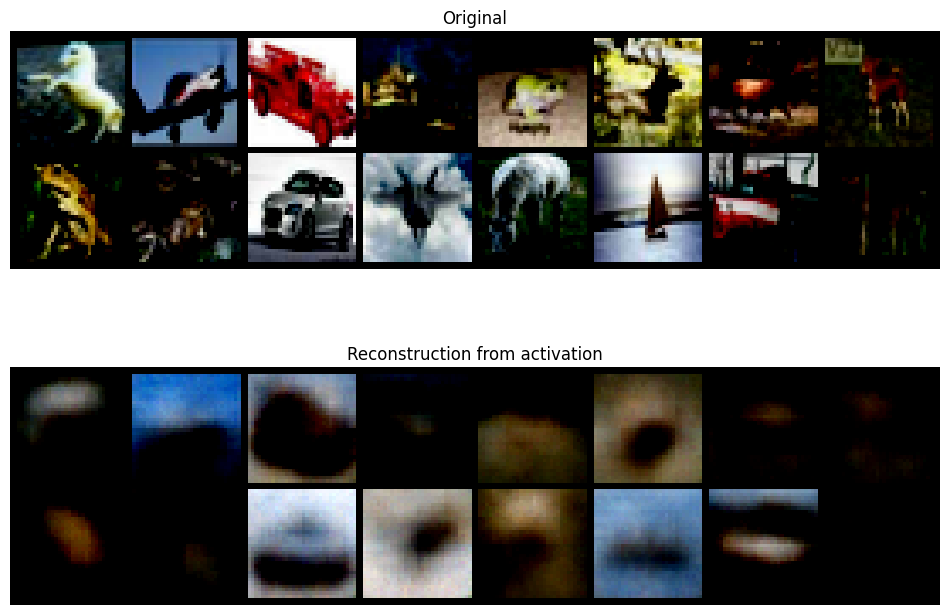

In [22]:
"""# Visualization of the adversary model performance"""

dataiter = iter(testloader)
batch = next(dataiter)
images, labels = batch[0].to(device), batch[1].to(device)

fig, axes = plt.subplots(2,1,figsize=(12,8))

axes[0].imshow(torchvision.utils.make_grid(images[0:16].cpu()).permute(1,2,0))
axes[0].axis('off')
axes[0].title.set_text("Original")

activations = client_model(images).detach()
reconstruction = adv_model(activations).detach()

axes[1].imshow(torchvision.utils.make_grid(reconstruction[0:16].cpu()).permute(1,2,0)) #grayscale representation of block
axes[1].axis("off")
axes[1].title.set_text("Reconstruction from activation")

While the information leakage has been reduced, a majority of the computation load is on the device

Can we do better?
Perhaps. Let's see the three broad degense categories

1. Adding noise to Z
2. Adversarial objective (model the prediction-reconstruction as min-max optimization)
3. Learn masking approaches on Z

We will introduce the Adversarial technique here and change the cut layer to 4.


Adversarial defense techniques

The core idea is to use a proxy adversary that tries to simulate the real world adversary and hence the client network can be trained to maximize the loss of the adversary

In [24]:
# Setup new defense pipeline
class AdversaryModelGen(nn.Module):
    """
    """
    def __init__(self):
        super(AdversaryModelGen,self).__init__()
        input_nc = 64
        output_nc = 3
        ngf = 32
        use_bias = False
        n_blocks = 2
        use_dropout = False
        padding_type = 'reflect'
        norm_layer = nn.BatchNorm2d

        model = [
                nn.Conv2d(input_nc,ngf,kernel_size = 3,padding=1,bias = use_bias),
                norm_layer(ngf),
                nn.ReLU(True),
        ]
        n_downsampling = 1

        for i in range(n_downsampling):
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult,ngf*mult*2,kernel_size =3,stride =2,padding =1,bias= use_bias),
                        norm_layer(ngf*mult*2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf*mult,padding_type=padding_type,norm_layer = norm_layer,use_dropout=use_dropout,use_bias=use_bias)]

        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling-i)
            model += [nn.ConvTranspose2d(ngf *mult,int(ngf *mult / 2),kernel_size =3,stride=2,padding=1,output_padding =1,bias = use_bias),
                        norm_layer(int(ngf*mult/2)),nn.ReLU(True)]

        n_upsampling_extra = 2 - n_downsampling
        for i in range(n_upsampling_extra):
            model += [nn.ConvTranspose2d(ngf,ngf,kernel_size=3,stride=2,padding=1,
                                            output_padding=1,bias=use_bias),
                        norm_layer(ngf),nn.ReLU(True)]
            if False and i == 0:
                model += [nn.Conv2d(ngf,ngf,kernel_size =2,stride=1,padding=0),
                            norm_layer(ngf),nn.ReLU(True)]

        model += [nn.ConvTranspose2d(ngf,output_nc,kernel_size=3,stride=2,padding=1,output_padding=1,bias= use_bias)]
        self.m = nn.Sequential(*model)

    def forward(self,x):
        for l in self.m:
            x = l(x)
        return x

# Adversarial Training

In [25]:
config = {"cut_layer": 4, "logits": 10}
client_model = ResNet18Client(config).to(device)
server_model = ResNet18Server(config).to(device)
adv_model = AdversaryModelGen().to(device)

criterion = nn.CrossEntropyLoss()

client_optimizer = optim.SGD(client_model.parameters(),lr=0.01,momentum=0.9)
server_optimizer = optim.SGD(server_model.parameters(),lr=0.01,momentum=0.9)
adv_optimizer = optim.SGD(adv_model.parameters(),lr=0.01,momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [26]:
num_epochs = 50
for epoch in range(num_epochs):
    running_loss_task, running_loss_adv, alpha = 0.0,0.0,0.1
    for i, data in enumerate(trainloader,0):
        inputs, labels = data[0].to(device) , data[1].to(device)

        client_optimizer.zero_grad()
        server_optimizer.zero_grad()

        # Client part
        activations = client_model(inputs)
        server_inputs = activations.detach().clone()
        adv_inputs = activations.detach().clone()

        # Simulation of server part is happining in this portion
        # Server part
        server_inputs = Variable(server_inputs,requires_grad=True)
        adv_inputs = Variable(adv_inputs,requires_grad=True)
        outputs = server_model(server_inputs)
        task_loss = criterion(outputs,labels)
        task_loss.backward()

        reconstruction = adv_model(adv_inputs)
        adv_loss = reconstruction_loss(reconstruction,inputs)
        adv_loss.backward()

        # Server Optimization
        server_optimizer.step()
        adv_optimizer.step()

        # Simulation of Client Happening in the portion
        # Client Optimization
        activations.backward(alpha * server_inputs.grad -(1-alpha) * adv_inputs.grad)
        client_optimizer.step()

        running_loss_task += task_loss.item()
        running_loss_adv += adv_loss.item()

        if i % 200 == 199:
            print('[{},{}] task_loss: {:.4f} adv_loss: {:.4f}'.format(epoch+1,i+1,running_loss_task/200,running_loss_adv/200))
            # running_loss = 0.0




[1,200] task_loss: 2.1460 adv_loss: 0.5056
[2,200] task_loss: 1.9853 adv_loss: 0.4244
[3,200] task_loss: 1.9496 adv_loss: 0.4283
[4,200] task_loss: 1.9859 adv_loss: 0.4243
[5,200] task_loss: 1.9283 adv_loss: 0.4236
[6,200] task_loss: 1.8914 adv_loss: 0.4241
[7,200] task_loss: 1.8972 adv_loss: 0.4238
[8,200] task_loss: 1.8576 adv_loss: 0.4230
[9,200] task_loss: 1.8273 adv_loss: 0.4234
[10,200] task_loss: 1.8080 adv_loss: 0.4236


KeyboardInterrupt: ignored

# Evaluation Pipeline

In [27]:
adv_model = AdversaryModelGen().to(device)
adv_optimizer = optim.SGD(adv_model.parameters(),lr= 0.01,momentum=0.9)

In [28]:
num_epochs = 50
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader,0):
        inputs, labels = data[0].to(device) , data[1].to(device)

        adv_optimizer.zero_grad()

        # Client part
        activations = client_model(inputs)
        server_inputs = activations.detach().clone()


        # Simulation of adversary part is happining in this portion
        server_inputs = Variable(server_inputs,requires_grad=True)
        outputs = adv_model(server_inputs)
        loss = reconstruction_loss(outputs,inputs)
        loss.backward()

        # Adversary Optimization
        adv_optimizer.step()

        running_loss += loss.item()

        if i % 200 == 199:
            print('[{},{}] loss: {}'.format(epoch+1,i+1,running_loss/200))
            running_loss = 0.0

[1,200] loss: 0.3527524020522833
[2,200] loss: 0.20159927904605865
[3,200] loss: 0.18273948445916177
[4,200] loss: 0.17488383583724498
[5,200] loss: 0.16969442494213582
[6,200] loss: 0.16603079304099083
[7,200] loss: 0.16340205557644366
[8,200] loss: 0.16087390355765818
[9,200] loss: 0.15926602579653262
[10,200] loss: 0.15667299464344978
[11,200] loss: 0.1545233002305031
[12,200] loss: 0.1537357559800148
[13,200] loss: 0.15164084814488887
[14,200] loss: 0.1500213862210512
[15,200] loss: 0.1487284679710865
[16,200] loss: 0.14751521974802018
[17,200] loss: 0.1466386156529188
[18,200] loss: 0.14554101273417472
[19,200] loss: 0.1448684737086296
[20,200] loss: 0.1437527083605528
[21,200] loss: 0.14299188911914826
[22,200] loss: 0.14287035159766673
[23,200] loss: 0.141859694942832
[24,200] loss: 0.14127355173230172
[25,200] loss: 0.14039996601641178
[26,200] loss: 0.13959516622126103
[27,200] loss: 0.13951120607554912
[28,200] loss: 0.13910402983427048
[29,200] loss: 0.13827916339039803
[30,

KeyboardInterrupt: ignored

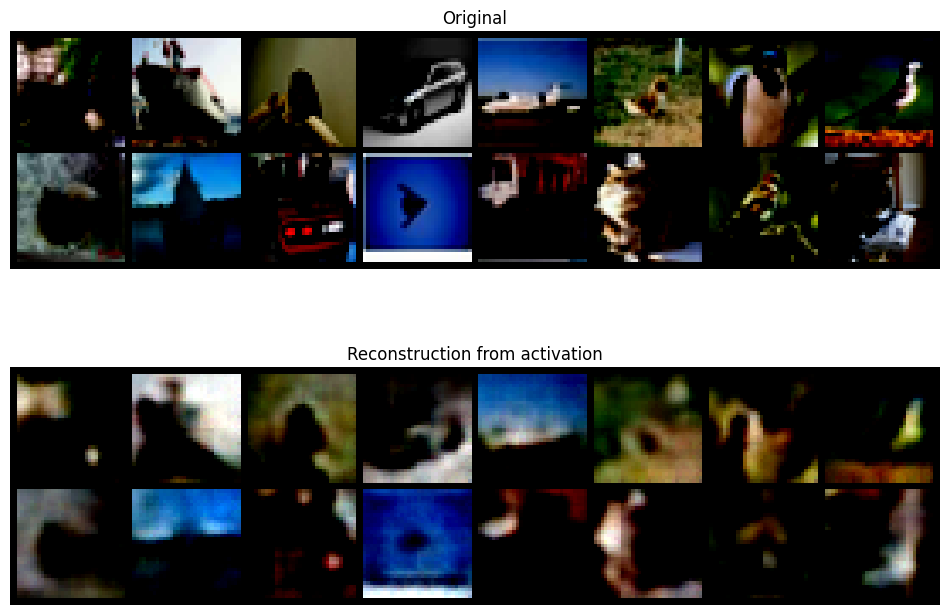

In [29]:
"""# Visualization of the adversary model performance"""

dataiter = iter(testloader)
batch = next(dataiter)
images, labels = batch[0].to(device), batch[1].to(device)

fig, axes = plt.subplots(2,1,figsize=(12,8))

axes[0].imshow(torchvision.utils.make_grid(images[0:16].cpu()).permute(1,2,0))
axes[0].axis('off')
axes[0].title.set_text("Original")

activations = client_model(images).detach()

reconstruction = adv_model(activations).detach()
axes[1].imshow(torchvision.utils.make_grid(reconstruction[0:16].cpu()).permute(1,2,0)) #grayscale representation of block
axes[1].axis("off")
axes[1].title.set_text("Reconstruction from activation")